In [1]:
import os
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"]="false"

In [20]:
import matplotlib.pyplot as plt
import jax.numpy as np
plt.rcParams.update({'font.size': 25})

In [3]:
%cd jax-morph

[Errno 2] No such file or directory: 'jax-morph'
/n/home10/rdeshpande/morphogenesis/data/paper


In [4]:
%cd ../../jax-morph

/n/home10/rdeshpande/morphogenesis/jax-morph


In [5]:
from jax import random, vmap
from jax_md import space, quantity, util
import jax_md.dataclasses as jdc

########## IMPORT JAX-MORPH FUNCTIONS ##########
################################################

from jax_morph.datastructures import SpaceFunc
from jax_morph.utils import _maybe_array, logistic
from jax_morph.simulation import simulation, sim_trajectory

# IMPORT STATE-CHANGING FUNCTIONS
from jax_morph.division_and_growth.cell_division import S_cell_division, S_cell_div_indep, S_cell_div_indep_MC
from jax_morph.division_and_growth.cell_growth import S_grow_cells

from jax_morph.mechanics.morse import S_mech_morse_relax
from jax_morph.cell_internals.stress import S_set_stress
from jax_morph.chemicals.secdiff import S_ss_chemfield

from jax_morph.cell_internals.divrates import S_set_divrate, div_nn
from jax_morph.cell_internals.secretion import sec_nn
from jax_morph.cell_internals.grad_estimate import S_chemical_gradients
from jax_morph.cell_internals.hidden_state import hidden_state_nn, S_hidden_state

from jax_morph.initial_states import init_state_grow

from jax_morph.visualization import draw_circles_ctype, draw_circles_chem, draw_circles_divrate, draw_circles
from Ramya.mech_homogeneous_growth.chemical import S_fixed_chemfield

from functools import partial
import equinox as eqx
import haiku as hk

In [6]:
# For saving data
import pickle
import os

# Loss curves

In [7]:
# Load results of optimizations of varying complexity
n_hidden = 8
with open('../data/paper/homogeneous_growth_100_hidden_' + str(n_hidden) + '_grads_power_law', 'rb') as handle:
    grads = pickle.load(handle)
with open('../data/paper/homogeneous_growth_100_hidden_' + str(n_hidden) + '_loss_power_law', 'rb') as handle:
    loss = pickle.load(handle)
with open('../data/paper/homogeneous_growth_100_hidden_' + str(n_hidden) + '_params_power_law', 'rb') as handle:
    param = pickle.load(handle)

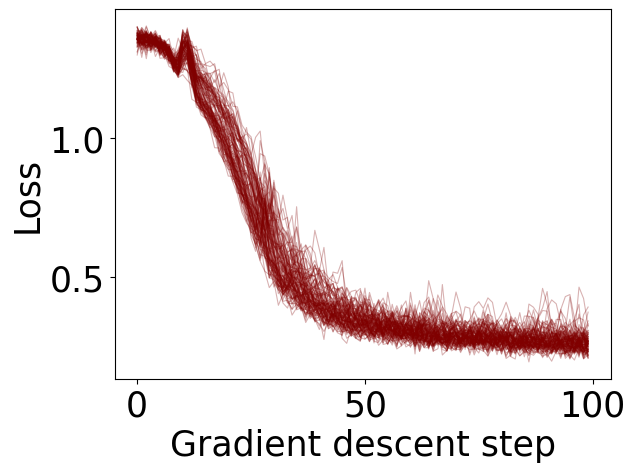

In [21]:
# Plot relevant losses
plt.plot(np.array(loss).T[:100, :], color="maroon", alpha=0.3, linewidth=0.8);
plt.xlabel('Gradient descent step')
plt.ylabel('Loss');
plt.savefig('../data/paper/figures/loss_power_law.svg')

# Forward simulations

In [8]:
#@title Define Params
# Define parameters --blue particles are type 1, orange are type 2
# keep type casting to place vars in gpu memory

# Number of chemical signals
n_chem = 2


### CELL DIMENSIONS
cellRad = .5
cellRadBirth = float(cellRad / np.sqrt(2))


### DIFFUSION

# No diffusion or secretion in my simulation - only external chemical field over positions
diffCoeff = np.ones(n_chem) 
degRate = np.ones(n_chem) 

# diffusion cutoff
r_cutoffDiff = 5.*cellRad
r_onsetDiff = r_cutoffDiff - .5

# CHEMICAL FIELD
chem_max = 50.0

### SECRETION

# sec rate that gives concentration 1 at source at SS
#sec_max_unitary = 2*np.sqrt(diffCoeff*degRate)

sec_max = np.ones((n_chem,), dtype=np.float32)
#sec_max = sec_max.at[0].set(10) 
#secreted_by_ctypes = np.ones((n_chem, 1))
ctype_sec_chem = np.ones((1, 2))

# GROWTH


# MORSE POTENTIAL
# always use python scalars
alpha = 3.0
eps_OneOne = 3.


# morse cutoff
r_cutoff = 5.*cellRad
r_onset = r_cutoff - .2


# number of gradient descent steps for Morse potential minimization
mech_relaxation_steps = 10


# Initialization and number of added cells. 
ncells_init = 100 #number of cells in the initial cluster
ncells_add = 100

hidden_state_size = 8


In [9]:
#@title Define trainable params
train_params = {
    'n_chem': False,
    'n_dim': False,
    'sec_max': True,
    'ctype_sec_chem': False,

    
    'cellRad' : False,
    'cellRadBirth' : False,
    
    'diffCoeff' : True,
    'degRate' : False,
    'r_onsetDiff' : False,
    'r_cutoffDiff' : False,
    
    'alpha': False, 
    'eps_OneOne': False,
    'r_onset' : False,
    'r_cutoff' : False,
    'mech_relaxation_steps' : False,
    
    'ncells_init' : False,
    'ncells_add': False,

    'chem_max': False, 
    'hidden_state_size': False
}

In [10]:
#@title Initialize params
params = {
    'n_chem': n_chem,
    'n_dim': 2,
    'sec_max': sec_max,
    'ctype_sec_chem' : ctype_sec_chem,
    
    'cellRad' : cellRad,
    'cellRadBirth' : cellRadBirth,
    
    'diffCoeff' : diffCoeff,
    'degRate' : degRate,
    'r_onsetDiff' : r_onsetDiff,
    'r_cutoffDiff' : r_cutoffDiff,
    
    'alpha': _maybe_array('alpha', alpha, train_params), 
    'eps_OneOne': _maybe_array('eps_OneOne', eps_OneOne, train_params),
    'r_onset' : r_onset,
    'r_cutoff' : r_cutoff,
    'mech_relaxation_steps' : mech_relaxation_steps,
    
    'ncells_init' : ncells_init,
    'ncells_add': ncells_add,

    'chem_max': chem_max,

    'hidden_state_size':  hidden_state_size,

}

In [11]:
# decorator MUST be jax_md.dataclass instead of dataclasses.dataclass
# to make dataclass compatible with jax tree operations
@jdc.dataclass
class CellState:
    '''
    Dataclass containing the system state.

    STATE
    -----

    '''

    # STATE
    position:   util.Array
    celltype:   util.Array
    radius:     util.Array
    chemical:   util.Array
    chemgrad:   util.Array
    field:     util.Array
    stress:   util.Array
    hidden_state: util.Array
    divrate:    util.Array
    key:        util.Array


    @classmethod
    def default_init(cls, n_dim=2, n_chem=1, hidden_size=10):
        '''
        Intializes a CellState with no cells (empty data structures, with correct shapes).
        

        Parameters
        ----------
        n_dim: int
            Number of spatial dimensions.
        n_chem: int
            Number of chemical species.

        Returns
        -------
        CellState
        '''

        assert n_dim == 2 or n_dim == 3, 'n_dim must be 2 or 3'
        assert n_chem > 0 and isinstance(n_chem, int), 'n_chem must be a positive integer'
        
        defaultstate = {
            'position'  :   np.empty(shape=(0, n_dim),              dtype=np.float32),
            'celltype'  :   np.empty(shape=(0,),                    dtype=np.int8),
            'radius'    :   np.empty(shape=(0,),                    dtype=np.float32),
            'chemical'  :   np.empty(shape=(0, n_chem),             dtype=np.float32),
            'chemgrad'  :   np.empty(shape=(0, int(n_dim*n_chem)),  dtype=np.float32),
            'field'   :      np.empty(shape=(0,),                   dtype=np.float32),
            'stress'  :   np.empty(shape=(0,),                      dtype=np.float32), 
            'hidden_state' : np.empty(shape=(0, hidden_size),       dtype=np.float32),
            'divrate'   :   np.empty(shape=(0,),                    dtype=np.float32),
            'key'       :   None,
        }


        return cls(**defaultstate)

In [12]:
# build space handling function and initial state
key = random.PRNGKey(0)
fspace = SpaceFunc(*space.free())
N_CELLS_INIT = params['ncells_init']
#generate empty data structure with correct shapes
istate = CellState.default_init(n_dim=params['n_dim'], 
                                n_chem=params['n_chem'],
                                hidden_size=params['hidden_state_size']
                                )

# populate initial state by growing from single cell
key, init_key = random.split(key)
istate = init_state_grow(init_key, istate, params, fspace, N_CELLS_INIT)

/n/home10/rdeshpande/.local/lib/python3.10/site-packages/jax/_src/numpy/reductions.py:209: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in sum is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return _reduction(a, "sum", np.sum, lax.add, 0, preproc=_cast_to_numeric,


In [13]:
#randomly initialize hidden states
from jax.nn import softplus
key, init_key = random.split(key)
hidden_state_init = softplus(10*(random.uniform(init_key, shape=istate.hidden_state.shape)*2 - 1))
istate = jdc.replace(istate, hidden_state=hidden_state_init)

In [14]:
# randomly initialize chemical species
key, init_key = random.split(key)
ichem = random.uniform(init_key, istate.chemical.shape)*params['sec_max']
istate = jdc.replace(istate, chemical=ichem)

In [15]:
#hidden neurons per layer
from jax.nn import tanh
HID_HIDDEN = [8]


#input fields to the network
use_state_fields = CellState(position=      False, 
                             celltype=      False, 
                             radius=            False, 
                             chemical=          True,
                             chemgrad=          True,
                             field=             False,
                             stress=            True,
                             divrate=           False,
                             hidden_state=      False,
                             key=           False
                            )


# init nn functions
hid_init, hid_nn_apply = hidden_state_nn(params,
                                         train_params,
                                         HID_HIDDEN,
                                         use_state_fields,
                                         train=True,
                                         transform_mlp_out=tanh,
                                         )


key, init_key = random.split(key)
params, train_params = hid_init(istate, init_key)

/n/home10/rdeshpande/morphogenesis/jax-morph/jax_morph/cell_internals/hidden_state.py:59: FutureWarning: jax.tree_leaves is deprecated, and will be removed in a future release. Use jax.tree_util.tree_leaves instead.
  in_fields = np.hstack([f if len(f.shape)>1 else f[:,np.newaxis] for f in jax.tree_leaves(eqx.filter(state, use_state_fields))])


In [16]:
#hidden neurons per layer
from jax.nn import sigmoid

DIV_HIDDEN = []
transform_mlp_out=sigmoid

#input fields to the network
use_state_fields_div = CellState(position=   False, 
                             celltype=   False, 
                             radius=     False, 
                             chemical=     False,
                             field=      False,
                             stress=    False,
                             chemgrad=   False,
                             hidden_state= True,
                             divrate=    False, 
                             key=        False
                            )
transform_fwd = lambda state, divrates: divrates*logistic(state.field, 0.1, 25.0)
#transform_fwd=None
# init nn functions
div_init, div_nn_apply = div_nn(params,
                                train_params,
                                DIV_HIDDEN,
                                use_state_fields_div,
                                train=True,
                                w_init=hk.initializers.Constant(0.0),
                                transform_mlp_out=sigmoid,
                                transform_fwd=transform_fwd,)

#initialize network parameters
key, init_key = random.split(key)
params, train_params = div_init(istate, init_key)

/n/home10/rdeshpande/morphogenesis/jax-morph/jax_morph/cell_internals/divrates.py:69: FutureWarning: jax.tree_leaves is deprecated, and will be removed in a future release. Use jax.tree_util.tree_leaves instead.
  in_fields = np.hstack([f if len(f.shape)>1 else f[:,np.newaxis] for f in jax.tree_leaves(eqx.filter(state, use_state_fields))])


In [17]:
#hidden neurons per layer
SEC_HIDDEN = []


#input fields to the network
use_state_fields_sec = CellState(position=   False, 
                             celltype=   False, 
                             radius=     False, 
                             chemical=      False,
                             chemgrad=   False,
                             field=      False,
                             stress=   False,
                             divrate=    False,
                             hidden_state= True, 
                             key=        False
                            )


# init nn functions
sec_init, sec_nn_apply = sec_nn(params,
                                train_params,
                                SEC_HIDDEN,
                                use_state_fields_sec,
                                w_init=hk.initializers.Constant(0.0),
                                train=True)


#initialize network parameters
key, init_key = random.split(key)
params, train_params = sec_init(istate, init_key)

/n/home10/rdeshpande/morphogenesis/jax-morph/jax_morph/cell_internals/secretion.py:52: FutureWarning: jax.tree_leaves is deprecated, and will be removed in a future release. Use jax.tree_util.tree_leaves instead.
  in_fields = np.hstack([f if len(f.shape)>1 else f[:,np.newaxis] for f in jax.tree_leaves(eqx.filter(state, use_state_fields))])


In [18]:
# functions in this list will be executed in the given order
# at each simulation step
from jax_morph.chemicals.diffusion import diffuse_allchem_ss_exp
fstep = [
    # ENV CHANGES
    S_cell_division,
    S_grow_cells,
    partial(S_mech_morse_relax, dt=.0001),
    partial(S_ss_chemfield, sec_fn=sec_nn_apply, diffusion_fn=diffuse_allchem_ss_exp,n_iter=3),

    # SENSING
    #chemicals sensed directly
    S_chemical_gradients,
    S_fixed_chemfield,
    S_set_stress,
    # INTERNAL (HIDDEN) STATE
    partial(S_hidden_state, dhidden_fn=eqx.filter_jit(hid_nn_apply), state_decay=.0),
    # POLICIES
    partial(S_set_divrate, divrate_fn=eqx.filter_jit(div_nn_apply))
]

In [19]:
# Run 100 different forward simulations with optimized results
def run_sim(key, sim_init, sim_step, params, istate, num_steps):
    sim_init, sim_step = simulation(fstep, params, fspace)
    fstate, _ = sim_trajectory(istate, sim_init, sim_step, num_steps, key, history=False)
    return fstate
run_sim_vmap = vmap(run_sim, in_axes=(0, None, None, None, None, None))

In [19]:
# Filter out lowest loss parameters
from jax.tree_util import tree_map
opt_filtered = np.argwhere(np.array(loss)[:, -1] < 0.16)
params_all = [eqx.combine(param[i][-1], params) for i in opt_filtered.flatten()]
stack = lambda *ys: np.stack(ys)

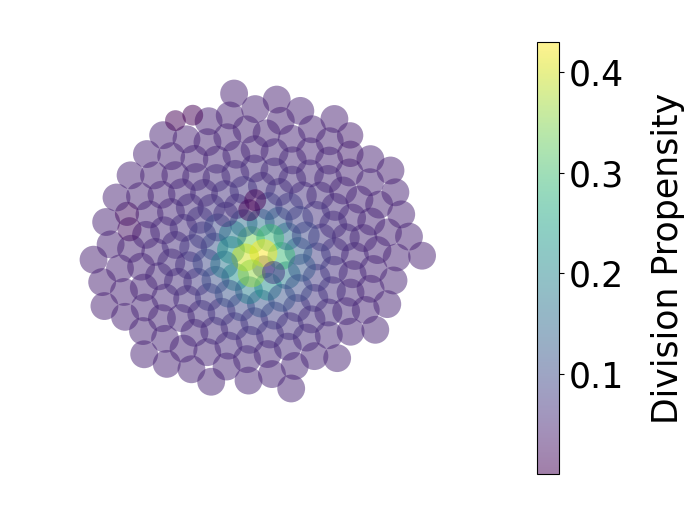

In [24]:
sim_init, sim_step = simulation(fstep, params, fspace)
fstate_unopt, _ = sim_trajectory(istate, sim_init, sim_step, 100, key, history=False)
draw_circles(fstate_unopt, fstate_unopt.divrate, cm=plt.cm.viridis, normalize=False, cbar_title="Division Propensity");
plt.savefig('../data/paper/figures/divrates_unopt.svg')

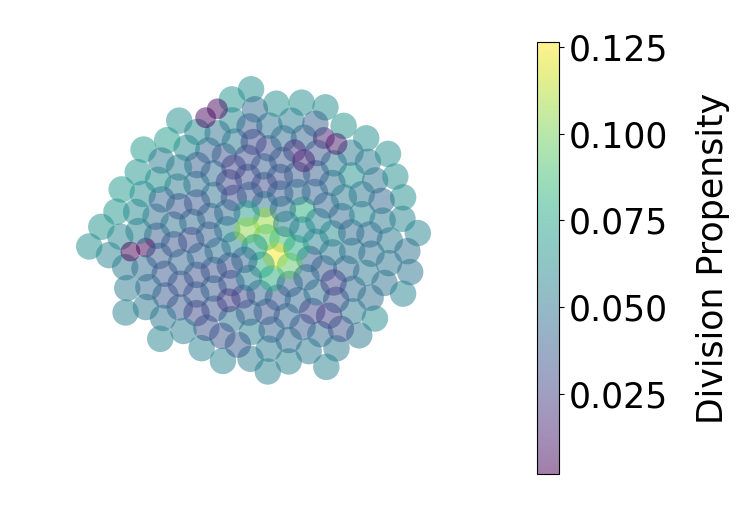

In [25]:
sim_init, sim_step = simulation(fstep, eqx.combine(params_all[0], params), fspace)
fstate_opt, _ = sim_trajectory(istate, sim_init, sim_step, 100, key, history=False)
draw_circles(fstate_opt, fstate_opt.divrate, cm=plt.cm.viridis, normalize=False, cbar_title="Division Propensity");
plt.savefig('../data/paper/figures/divrates_opt.svg')

In [27]:
transform_fwd_inv = lambda state, divrates: divrates/logistic(state.field, 0.1, 25.0)

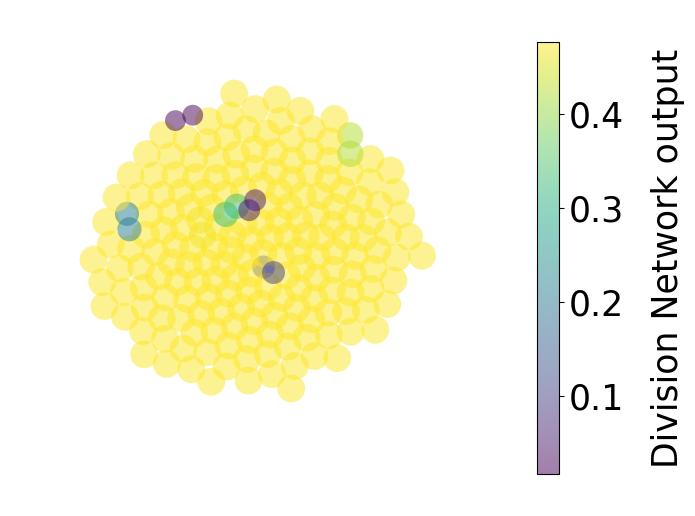

In [28]:
# Plot just division outputs (without scaling factor)
transform_fwd_inv = lambda state, divrates: divrates/logistic(state.field, 0.1, 25.0)
draw_circles(fstate_unopt, transform_fwd_inv(fstate_unopt, fstate_unopt.divrate), cm=plt.cm.viridis, normalize=False, cbar_title="Division Network output")
plt.savefig('../data/paper/figures/divoutputs_unopt.svg')

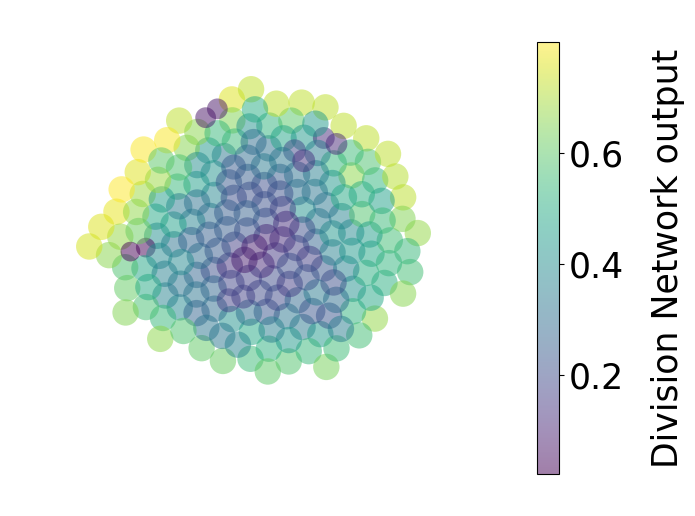

In [29]:
# Plot just division outputs (without scaling factor)
transform_fwd_inv = lambda state, divrates: divrates/logistic(state.field, 0.1, 25.0)
draw_circles(fstate_opt, transform_fwd_inv(fstate_opt, fstate_opt.divrate), normalize=False, cm=plt.cm.viridis, cbar_title="Division Network output")
plt.savefig('../data/paper/figures/divoutputs_opt.svg')

In [64]:
# Make range of N numbers from 5th to 95th percentile of value
from jax.nn import leaky_relu
def make_range(N, traj_vals):
    return np.linspace(np.percentile(traj_vals.flatten(), 5), np.percentile(traj_vals.flatten(), 95), N) 
# Internal guts of the networks

# Hidden
n_hidden = [8]
transform_mlp_out=tanh
def _hidden_nn(in_fields):
    mlp = hk.nets.MLP(n_hidden+[params['hidden_state_size']],
                        activation=leaky_relu,
                        w_init=None,
                        activate_final=False
                        )
        
    out = mlp(in_fields)
    out = transform_mlp_out(out)

    return out
_hidden_nn = hk.without_apply_rng(hk.transform(_hidden_nn))

# Division
n_hidden_div, n_hidden_sec = [], []
transform_mlp_out = sigmoid
def _div_nn(in_fields):
    mlp = hk.nets.MLP(n_hidden_div+[1],
                      activation=leaky_relu,
                      activate_final=False,
                      w_init=hk.initializers.Constant(0.0),
                        )
        
    out = mlp(in_fields)
    out = transform_mlp_out(out)
    return out
_div_nn = hk.without_apply_rng(hk.transform(_div_nn))

# Secretion
def _sec_nn(in_fields):
    mlp = hk.nets.MLP(n_hidden_sec+[params['n_chem']],
                        activation=leaky_relu,
                        activate_final=False,
                        w_init=hk.initializers.Constant(0.0),
                        )
        
    out = mlp(in_fields)
    out = transform_mlp_out(out)
    return out
_sec_nn = hk.without_apply_rng(hk.transform(_sec_nn))

In [65]:
# Plot div_nn output for different values of chemicals and stresses
def get_div_output(key, params_to_use, traj, c=0):
        chem1 = np.median(traj[0].chemical[:, :, 1 - c].flatten())
        chem2 = make_range(20, traj[0].chemical[:, :, c])
        chem1_x = np.median(traj[0].chemgrad[:, :, 0])
        chem1_y = np.median(traj[0].chemgrad[:, :, 1])
        chem2_x = np.median(traj[0].chemgrad[:, :, 2])
        chem2_y = np.median(traj[0].chemgrad[:, :, 3])
        stress_range = make_range(20, traj[0].stress[:])
        x, y = np.meshgrid(chem2, stress_range)
        plotting_data = (x, y)
        input_data = np.vstack((np.repeat(chem1, 400), x.flatten(), np.repeat(chem1_x, 400), np.repeat(chem1_y, 400), np.repeat(chem2_x, 400), np.repeat(chem2_y, 400), y.flatten())).T
        _ = _hidden_nn.init(key, np.ones(input_data.shape))
        hidden_output = _hidden_nn.apply(params_to_use["hidden_fn"].copy(), input_data)
        _ = _div_nn.init(key, np.ones(np.array(hidden_output).shape))
        div_output = _div_nn.apply(params_to_use["div_fn"].copy(), hidden_output).flatten()
        return plotting_data, div_output

In [66]:
# Plot div_nn output for different values of chemicals and stresses
def get_sec_output(key, params_to_use, traj, c=0):
        chem1 = np.median(traj[0].chemical[:, :, 1 - c].flatten())
        chem2 = make_range(20, traj[0].chemical[:, :, c])
        chem1_x = np.median(traj[0].chemgrad[:, :, 0])
        chem1_y = np.median(traj[0].chemgrad[:, :, 1])
        chem2_x = np.median(traj[0].chemgrad[:, :, 2])
        chem2_y = np.median(traj[0].chemgrad[:, :, 3])
        stress_range = make_range(20, traj[0].stress[:])
        x, y = np.meshgrid(chem2, stress_range)
        plotting_data = (x, y)
        input_data = np.vstack((np.repeat(chem1, 400), x.flatten(), np.repeat(chem1_x, 400), np.repeat(chem1_y, 400), np.repeat(chem2_x, 400), np.repeat(chem2_y, 400), y.flatten())).T
        _ = _hidden_nn.init(key, np.ones(input_data.shape))
        hidden_output = _hidden_nn.apply(params_to_use["hidden_fn"].copy(), input_data)
        _ = _sec_nn.init(key, np.ones(np.array(hidden_output).shape))
        sec_output = _sec_nn.apply(params_to_use["sec_fn"].copy(), hidden_output).flatten()
        return plotting_data, sec_output

Text(0.5, 1.0, 'Chemical 2')

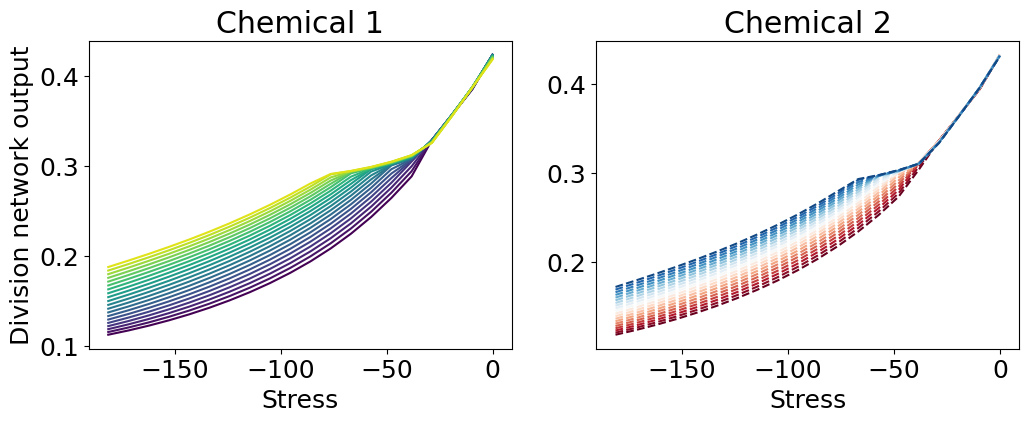

In [67]:
#for i, p in enumerate(params_all[2]):
# 8
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
p = params_all[12]
i = 2
sim_init, sim_step = simulation(fstep, p, fspace)
opt_fstate, opt_traj = sim_trajectory(istate, sim_init, sim_step, 100, key, history=True)
(x, y), div_output = get_div_output(key, p.copy(), opt_traj)
(x2, y2), div_output2 = get_div_output(key, p.copy(), opt_traj, c=1)

for j in range(20):
    ax[0].plot(y.T[j], div_output.reshape(20, 20).T[j], c=plt.cm.viridis(j/20));
    ax[1].plot(y2.T[j], div_output2.reshape(20, 20).T[j], c=plt.cm.RdBu(j/20), linestyle="dashed");
ax[0].set_xlabel("Stress")
ax[1].set_xlabel("Stress")
ax[0].set_ylabel("Division network output")
ax[0].set_title("Chemical 1")
ax[1].set_title("Chemical 2")

Text(0.5, 1.0, 'Chemical 2')

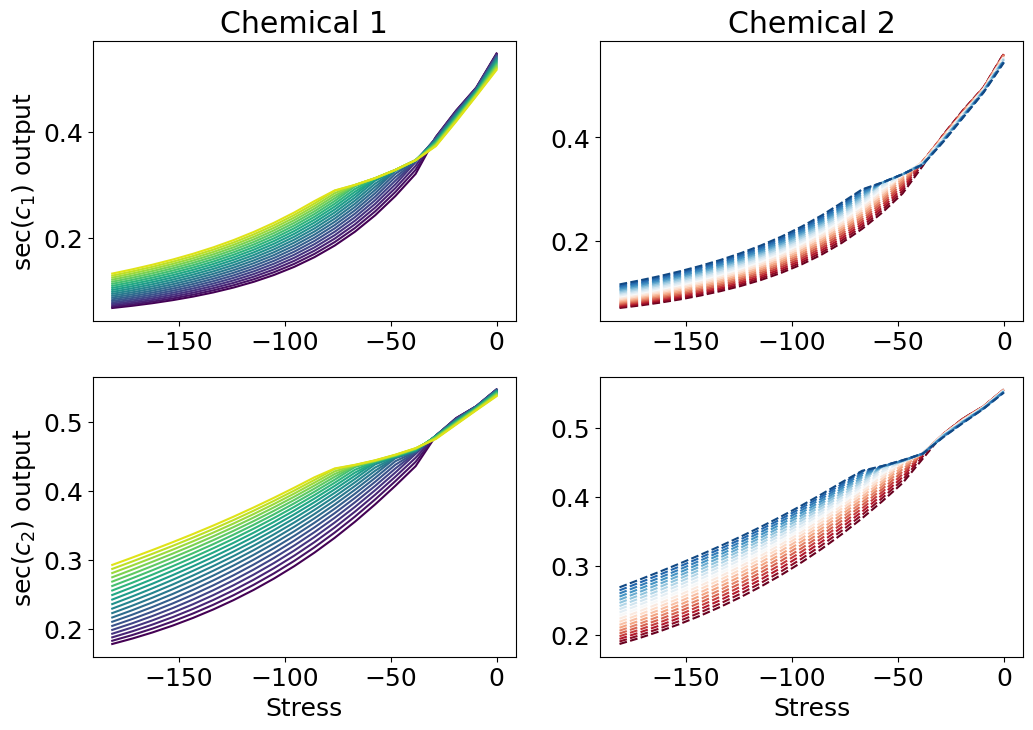

In [68]:
#for i, p in enumerate(params_all[2]):
# 8
fig, ax = plt.subplots(2, 2, figsize=(12, 8))
p = params_all[12]
i = 2
sim_init, sim_step = simulation(fstep, p, fspace)
opt_fstate, opt_traj = sim_trajectory(istate, sim_init, sim_step, 100, key, history=True)
(x, y), sec_output = get_sec_output(key, p.copy(), opt_traj)
(x2, y2), sec_output2 = get_sec_output(key, p.copy(), opt_traj, c=1)

for j in range(20):
    ax[0][0].plot(y.T[j], sec_output.reshape(20, 20, 2).T[0, j], c=plt.cm.viridis(j/20));
    ax[0][1].plot(y2.T[j], sec_output2.reshape(20, 20, 2).T[0, j], c=plt.cm.RdBu(j/20), linestyle="dashed");
    ax[1][0].plot(y.T[j], sec_output.reshape(20, 20, 2).T[1, j], c=plt.cm.viridis(j/20));
    ax[1][1].plot(y2.T[j], sec_output2.reshape(20, 20, 2).T[1, j], c=plt.cm.RdBu(j/20), linestyle="dashed");
ax[1][0].set_xlabel("Stress")
ax[1][1].set_xlabel("Stress")
ax[0][0].set_ylabel(r"sec($c_1$) output")
ax[1][0].set_ylabel(r"sec($c_2$) output")
ax[0][0].set_title("Chemical 1")
ax[0][1].set_title("Chemical 2")

# Run for longer than optimization period

How well does learned mechanism generalize to more timesteps? To perturbations and/or noise?

In [70]:
# Run simulations for longer timesteps
keys = random.split(key, 20)
unopt_fstates = run_sim_vmap(keys[:10], sim_init, sim_step, params, istate, 200)
opt_fstates = run_sim_vmap(keys[10:20], sim_init, sim_step, eqx.combine(params_all[0], params), istate, 200)

/n/home10/rdeshpande/.local/lib/python3.10/site-packages/jax/_src/numpy/reductions.py:209: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in sum is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return _reduction(a, "sum", np.sum, lax.add, 0, preproc=_cast_to_numeric,


In [71]:
# Run one simulation per set of optimized parameters
opt_traj_all_200 = []
for i in range(5):
    key, _ = random.split(key)
    sim_init, sim_step = simulation(fstep, params_all[0], fspace)
    fstate, traj = sim_trajectory(istate, sim_init, sim_step, 200, key, history=True)
    opt_traj_all_200.append(traj[0])
opt_traj_all_200 = tree_map(stack, *opt_traj_all_200)

In [72]:
unopt_traj_all_200 = []
for i in range(5):
    key, _ = random.split(key)
    sim_init, sim_step = simulation(fstep, params, fspace)
    fstate, traj = sim_trajectory(istate, sim_init, sim_step, 200, key, history=True)
    unopt_traj_all_200.append(traj[0])
unopt_traj_all_200 = tree_map(stack, *unopt_traj_all_200)

2023-10-11 16:05:38.715810: E external/xla/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_scan] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************


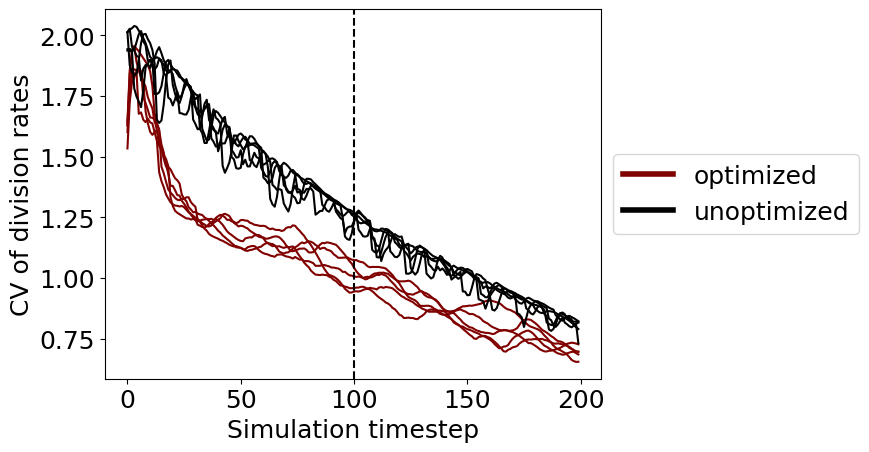

In [ ]:
from matplotlib.lines import Line2D
plt.plot((np.std(opt_traj_all_200.divrate, axis=2)/np.mean(opt_traj_all_200.divrate, axis=2)).T, color='maroon', label="unoptimized");
plt.plot((np.std(unopt_traj_all_200.divrate, axis=2)/np.mean(unopt_traj_all_200.divrate, axis=2)).T, color='black', label="optimized");
plt.axvline(100, linestyle="dashed", color="black")
plt.xlabel("Simulation timestep")
plt.ylabel("CV of division rates");
# Make custom legend
custom_lines = [Line2D([0], [0], color='maroon', lw=4), Line2D([0], [0], color='black', lw=4)]
labels=["optimized", "unoptimized"]
plt.legend(custom_lines, labels, loc='center left', bbox_to_anchor=(1, 0.5))

# Chemical field change

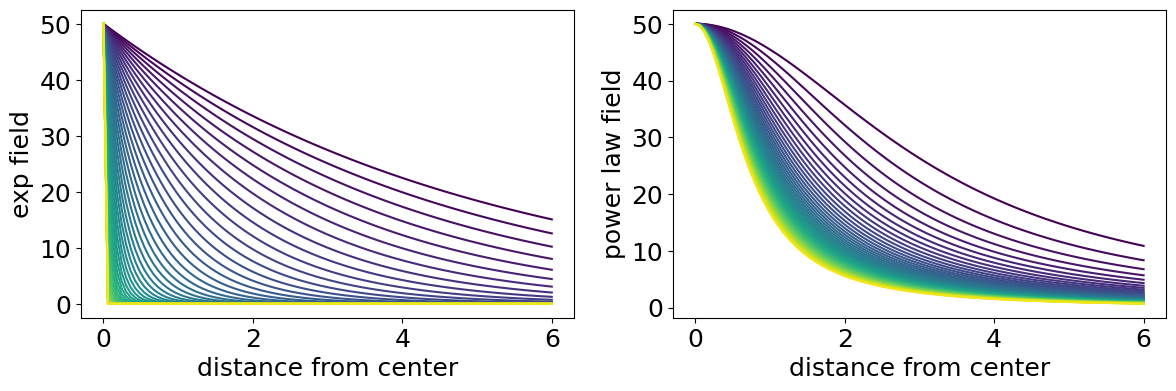

In [25]:
xs = np.linspace(0.0, 6.0, 100)
N = 50

exp_ks = np.array([2*10**i for i in np.linspace(-1, 2, N)])
power_ks = np.linspace(0.1, 2.0, N)

exp_ys = np.array([50*np.exp(-exp_k*xs) for exp_k in exp_ks])
power_ys = np.array([50/(1 + power_k*xs**2) for power_k in power_ks])

fig, ax = plt.subplots(1, 2, figsize=(14, 4))
for i in range(N):
  ax[0].plot(np.linspace(0.0, 6.0, 100), exp_ys[i], c = plt.cm.viridis(i/N))
  ax[1].plot(np.linspace(0.0, 6.0, 100), power_ys[i], c = plt.cm.viridis(i/N))

ax[0].set_xlabel('distance from center')
ax[0].set_ylabel("exp field");
ax[1].set_xlabel("distance from center")
ax[1].set_ylabel("power law field");

In [24]:
def exp_chemfield(state, params, fspace, chem_max=50.0, chem_k=1.0):
    center = np.array([0.0, 0.0])
    chemfield_disp = vmap(fspace.displacement, (0, None))(state.position, center)
    chemfield_disp = np.linalg.norm(chemfield_disp, axis=1)
    chemfield = chem_max*np.exp(-chem_k*chemfield_disp)
    chemfield = np.where(state.celltype > 0, chemfield, 0.0) 
    state = jdc.replace(state, field=chemfield)
    return state

In [26]:
def power_chemfield(state, params, fspace, chem_max=50.0, chem_k=1.0):
    center = np.array([0.0, 0.0])
    chemfield_disp = vmap(fspace.displacement, (0, None))(state.position, center)
    chemfield_disp = np.linalg.norm(chemfield_disp, axis=1)
    chemfield = chem_max/(1 + chem_k*np.power(chemfield_disp, 2))
    chemfield = np.where(state.celltype > 0, chemfield, 0.0) #+ noise*random.normal(istate.key, chemfield.shape)
    state = jdc.replace(state, field=chemfield)
    return state

In [19]:
# Run simulation for different chemical fields
def run_sim_field(key, chem_k, chem_max, chem_function, sim_init, sim_step, p, istate, num_steps):
    fstep = [
    # ENV CHANGES
    S_cell_division,
    S_grow_cells,
    partial(S_mech_morse_relax, dt=.0001),
    partial(S_ss_chemfield, sec_fn=sec_nn_apply, n_iter=3),
    # SENSING
    #chemicals sensed directly
    S_chemical_gradients,
    partial(chem_function, chem_max=chem_max, chem_k=chem_k),
    S_set_stress,
    # INTERNAL (HIDDEN) STATE
    partial(S_hidden_state, dhidden_fn=eqx.filter_jit(hid_nn_apply), state_decay=.0),
    # POLICIES
    partial(S_set_divrate, divrate_fn=eqx.filter_jit(div_nn_apply))
    ]
    sim_init, sim_step = simulation(fstep, p, fspace)
    fstate, _ = sim_trajectory(istate, sim_init, sim_step, num_steps, key, history=False)
    return fstate
run_sim_field_vmap = vmap(run_sim_field, in_axes=(0, None, None, None, None, None, None, None, None))
run_sim_field_vmap_k = vmap(run_sim_field, in_axes=(0, 0, None, None, None, None, None, None, None))

In [35]:
keys = random.split(key, N)
unopt_fstates_power_k = run_sim_field_vmap_k(keys, power_ks, 50.0, power_chemfield, sim_init, sim_step, params, istate, 100)
opt_fstates_power_k = run_sim_field_vmap_k(keys, power_ks, 50.0, power_chemfield, sim_init, sim_step, params_all[0], istate, 100)
unopt_fstates_exp_k = run_sim_field_vmap_k(keys, exp_ks, 50.0, exp_chemfield, sim_init, sim_step, params, istate, 100)
opt_fstates_exp_k = run_sim_field_vmap_k(keys, exp_ks, 50.0, exp_chemfield, sim_init, sim_step, params_all[0], istate, 100)

Text(0, 0.5, 'CV divrates')

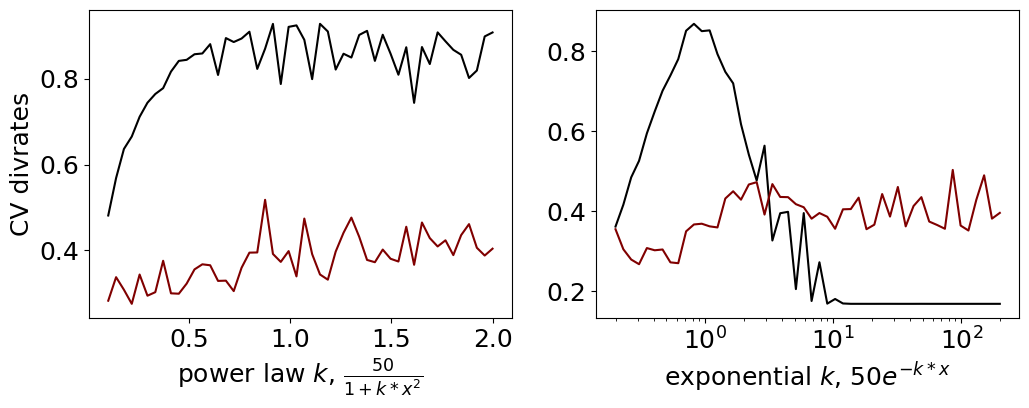

In [36]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(power_ks, np.std(unopt_fstates_power_k.divrate, axis=1)/np.mean(unopt_fstates_power_k.divrate, axis=1), color='black', label="unoptimized");
ax[0].plot(power_ks, np.std(opt_fstates_power_k.divrate, axis=1)/np.mean(opt_fstates_power_k.divrate, axis=1), color='maroon', label="optimized");
ax[1].plot(exp_ks, np.std(unopt_fstates_exp_k.divrate, axis=1)/np.mean(unopt_fstates_exp_k.divrate, axis=1), color='black', label="unoptimized");
ax[1].plot(exp_ks, np.std(opt_fstates_exp_k.divrate, axis=1)/np.mean(opt_fstates_exp_k.divrate, axis=1), color='maroon', label="optimized");
ax[0].set_xlabel(r"power law $k$, $\frac{50}{1 + k*x^2}$")
ax[1].set_xlabel(r"exponential $k$, $50e^{-k*x}$")
ax[1].set_xscale("log")
ax[0].set_ylabel("CV divrates")

# A "nutty" field

In [20]:
def gradient_chemfield(state, params, fspace, chem_max=50.0, chem_k=1.0):
    y_disp = state.position[:, 1] - state.position[:, 1].min()
    chemfield = 5.0*y_disp
    chemfield = np.where(state.celltype > 0, chemfield, 0.0) 
    state = jdc.replace(state, field=chemfield)
    return state

In [40]:
uopt_grad_fstate = run_sim_field(key, 0.0, 0.0, gradient_chemfield, sim_init, sim_step, params, istate, 100)
opt_grad_fstate = run_sim_field(key, 0.0, 0.0, gradient_chemfield, sim_init, sim_step, params_all[0], istate, 100)

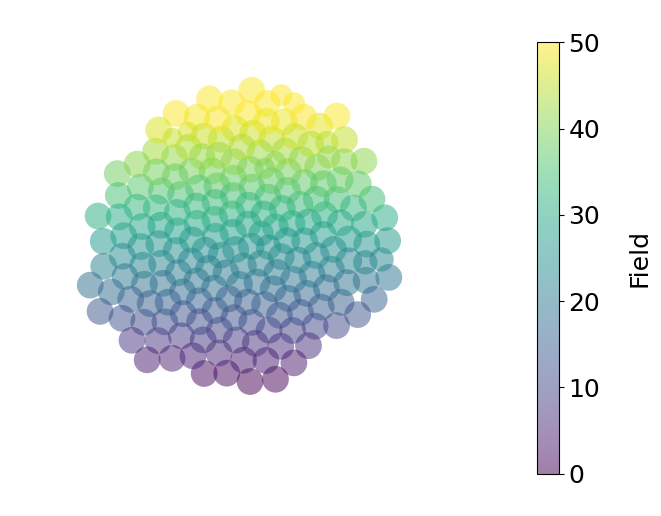

In [42]:
draw_circles(uopt_grad_fstate, uopt_grad_fstate.field, min_val=0.0, max_val=50.0, cm=plt.cm.viridis, cbar_title="Field");
plt.savefig('../data/paper/figures/gradfield_unopt_field.svg')

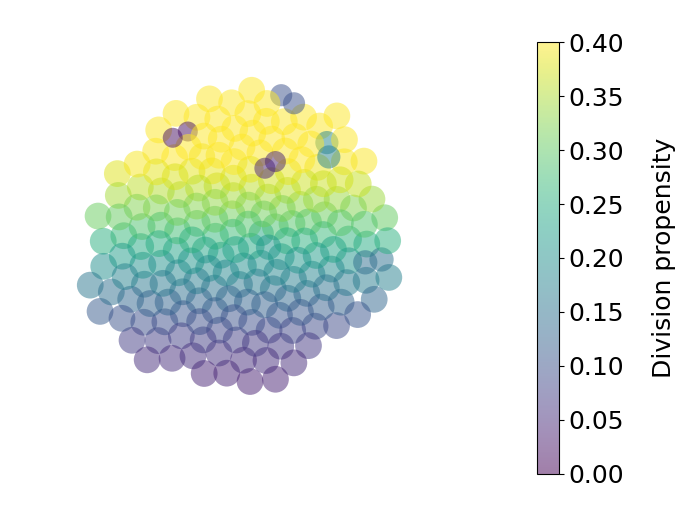

In [46]:
draw_circles(uopt_grad_fstate, uopt_grad_fstate.divrate, cm=plt.cm.viridis, min_val=0.0, max_val=0.4, cbar_title="Division propensity");
plt.savefig('../data/paper/figures/gradfield_unopt_divrates.svg')

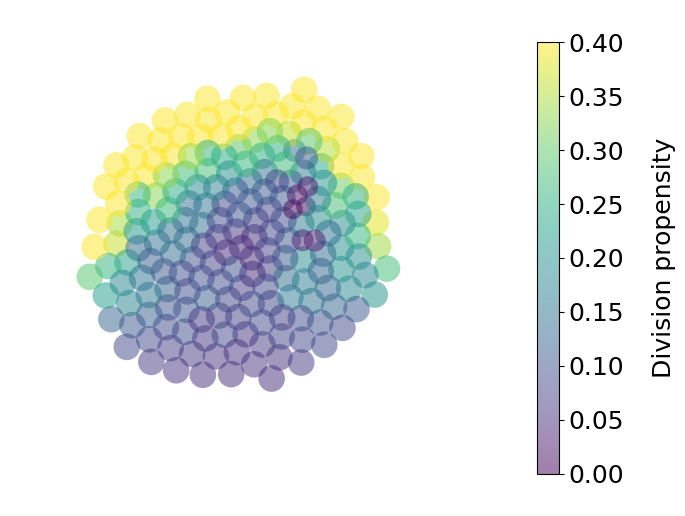

In [45]:
draw_circles(opt_grad_fstate, opt_grad_fstate.divrate, cm=plt.cm.viridis, min_val=0.0, max_val=0.4, cbar_title="Division propensity");
plt.savefig('../data/paper/figures/gradfield_opt_divrates.svg')

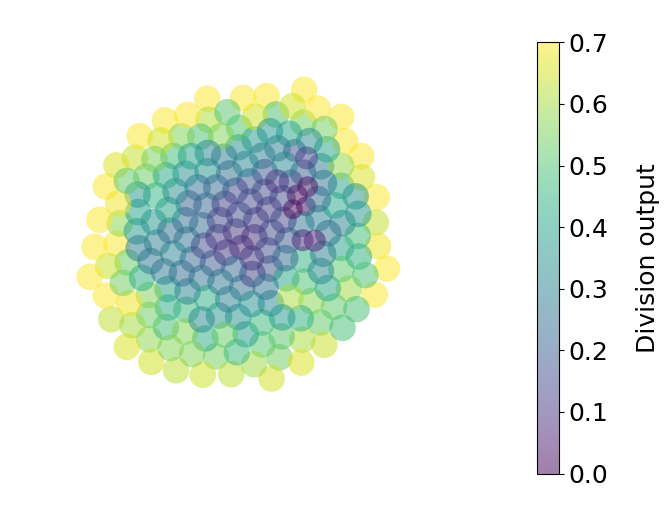

In [70]:
div_outputs = transform_fwd_inv(opt_grad_fstate, opt_grad_fstate.divrate)
draw_circles(opt_grad_fstate, div_outputs, cm=plt.cm.viridis, min_val=0.0, max_val=0.7, cbar_title="Division output");
plt.savefig('../data/paper/figures/gradfield_opt_divoutputs.svg')

In [21]:
def two_peaks_chemfield(state, params, fspace, chem_max=50.0, chem_k=1.0):
    centers = np.array([[-3.0, 0.0], [3.5, 0.0]])
    chemfield_disp1 = np.reshape(np.linalg.norm(vmap(fspace.displacement, (0, None))(state.position, centers[0]), axis=1), (-1, 1))
    chemfield_disp2 = np.reshape(np.linalg.norm(vmap(fspace.displacement, (0, None))(state.position, centers[1]), axis=1), (-1, 1))
    peak_mask = np.argmin(np.hstack((chemfield_disp1, chemfield_disp2)), axis=1)
    chemfield = np.where(peak_mask, chemfield_disp2[:, 0], chemfield_disp1[:, 0])
    chemfield = 100/(1 + 0.8*chemfield**2)
    state = jdc.replace(state, field=chemfield)
    return state

In [54]:
uopt_peaks_fstate = run_sim_field(key, 0.0, 0.0, two_peaks_chemfield, sim_init, sim_step, params, istate, 100)
opt_peaks_fstate = run_sim_field(key, 0.0, 0.0, two_peaks_chemfield, sim_init, sim_step, params_all[0], istate, 100)

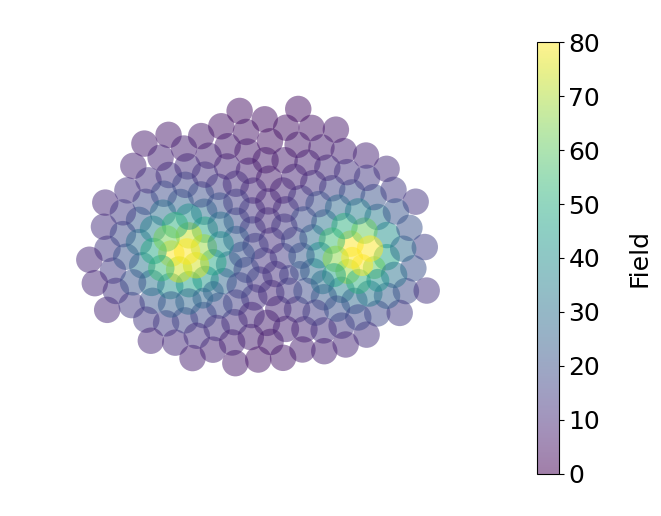

In [55]:
draw_circles(uopt_peaks_fstate, uopt_peaks_fstate.field, min_val=0.0, max_val=80.0, cm=plt.cm.viridis, cbar_title="Field");
plt.savefig('../data/paper/figures/twopeaks_unopt_field.svg')

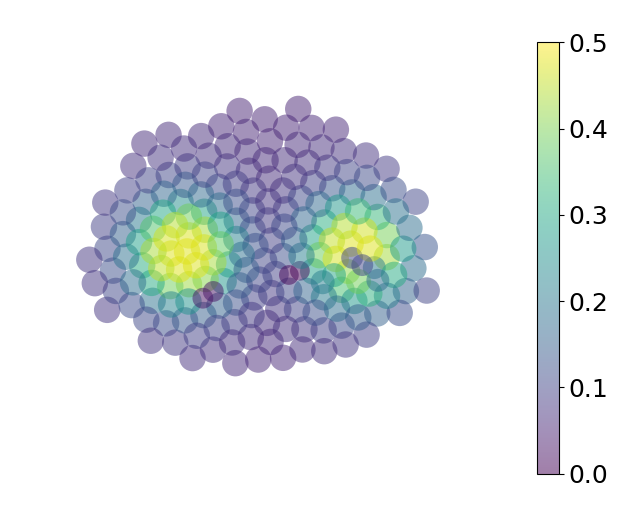

In [56]:
draw_circles(uopt_peaks_fstate, uopt_peaks_fstate.divrate, cm=plt.cm.viridis, min_val=0.0, max_val=0.5);
plt.savefig('../data/paper/figures/twopeaks_unopt_divrates.svg')

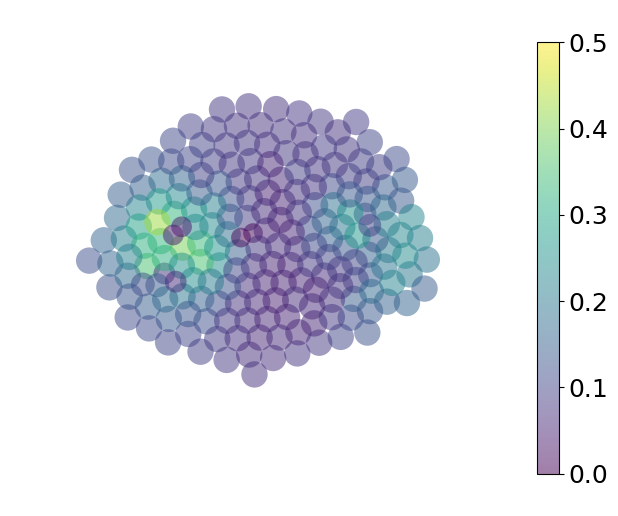

In [57]:
draw_circles(opt_peaks_fstate, opt_peaks_fstate.divrate, cm=plt.cm.viridis, min_val=0.0, max_val=0.5);
plt.savefig('../data/paper/figures/twopeaks_opt_divrates.svg')

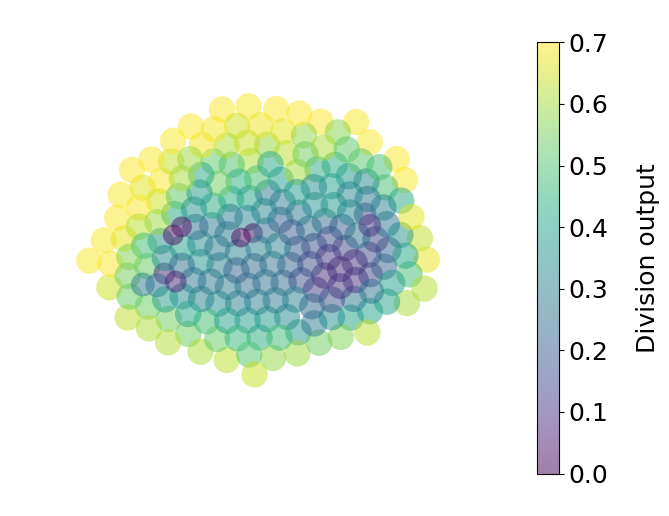

In [71]:
div_outputs = transform_fwd_inv(opt_peaks_fstate, opt_peaks_fstate.divrate)
draw_circles(opt_peaks_fstate, div_outputs, cm=plt.cm.viridis, cbar_title="Division output", min_val=0.0, max_val=0.7);
plt.savefig('../data/paper/figures/twopeaks_opt_divoutputs.svg')

In [22]:
def off_center_chemfield(state, params, fspace, chem_max=50.0, chem_k=1.0):
    center = np.array([-4.0, 0.0])
    chemfield_disp = vmap(fspace.displacement, (0, None))(state.position, center)
    chemfield_disp = np.linalg.norm(chemfield_disp, axis=1)
    # TODO: Write these out as params
    chemfield = 100/(2 + 0.8*np.power(chemfield_disp, 2.0))
    chemfield = np.where(state.celltype > 0, chemfield, 0.0) #+ noise*random.normal(istate.key, chemfield.shape)
    state = jdc.replace(state, field=chemfield)
    return state

In [63]:
uopt_off_fstate = run_sim_field(key, 0.0, 0.0, off_center_chemfield, sim_init, sim_step, params, istate, 100)
opt_off_fstate = run_sim_field(key, 0.0, 0.0, off_center_chemfield, sim_init, sim_step, params_all[0], istate, 100)

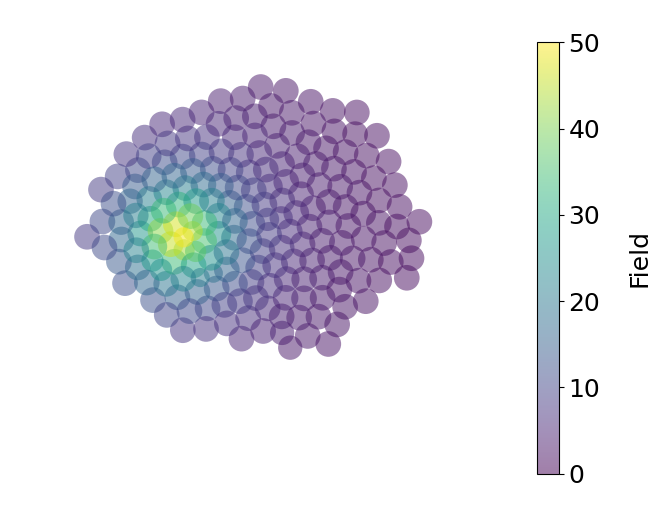

In [64]:
draw_circles(uopt_off_fstate, uopt_off_fstate.field, min_val=0.0, max_val=50.0, cm=plt.cm.viridis, cbar_title="Field");
plt.savefig('../data/paper/figures/offcenter_unopt_field.svg')

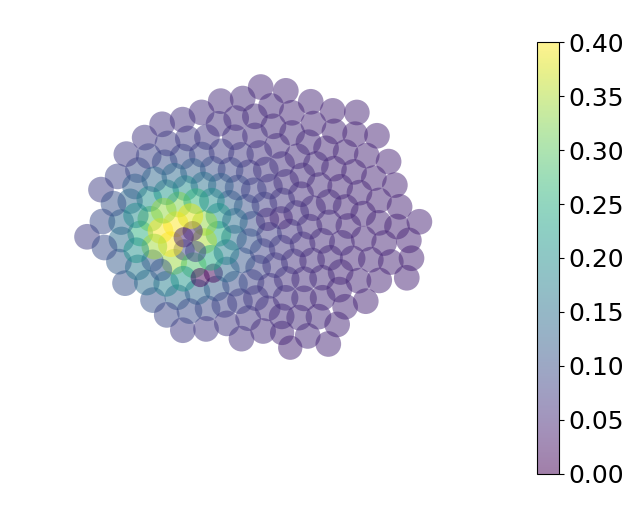

In [66]:
draw_circles(uopt_off_fstate, uopt_off_fstate.divrate, cm=plt.cm.viridis, min_val=0.0, max_val=0.4);
plt.savefig('../data/paper/figures/offcenter_unopt_divrates.svg')

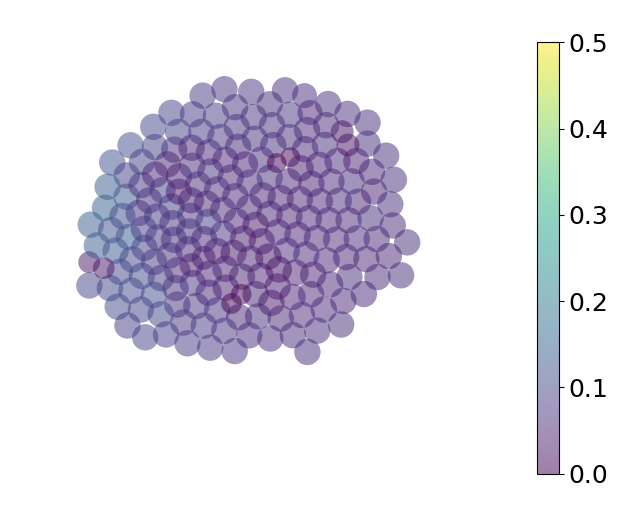

In [67]:
draw_circles(opt_off_fstate, opt_off_fstate.divrate, cm=plt.cm.viridis, min_val=0.0, max_val=0.5);
plt.savefig('../data/paper/figures/offcenter_opt_divrates.svg')

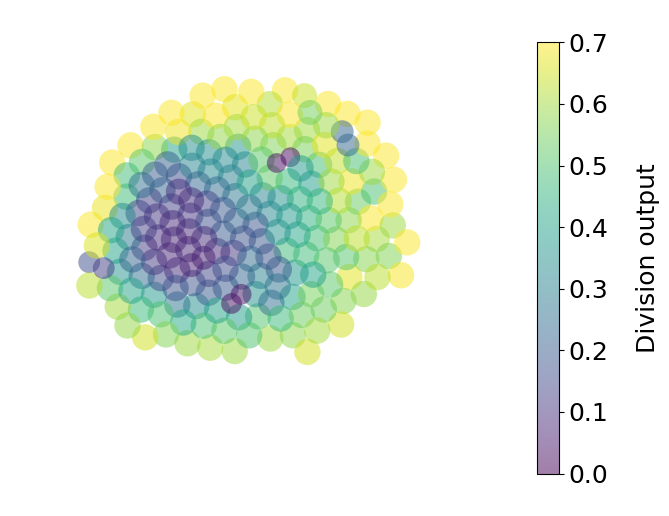

In [72]:
div_outputs = transform_fwd_inv(opt_off_fstate, opt_off_fstate.divrate)
draw_circles(opt_off_fstate, div_outputs, cm=plt.cm.viridis, cbar_title="Division output", min_val=0.0, max_val=0.7);
plt.savefig('../data/paper/figures/offcenter_opt_divoutputs.svg')

In [27]:
# Run 100 optimizations with each field type
keys = random.split(key, 100)
gradfield = run_sim_field_vmap(keys[:50], 0.0, 0.0, gradient_chemfield, sim_init, sim_step, params, istate, 100)
gradfield_opt = run_sim_field_vmap(keys[50:], 0.0, 0.0, gradient_chemfield, sim_init, sim_step, params_all[0], istate, 100)
twopeaks = run_sim_field_vmap(keys[:50], 0.0, 0.0, two_peaks_chemfield, sim_init, sim_step, params, istate, 100)
twopeaks_opt = run_sim_field_vmap(keys[50:], 0.0, 0.0, two_peaks_chemfield, sim_init, sim_step, params_all[0], istate, 100)
offcenter = run_sim_field_vmap(keys[:50], 0.0, 0.0, off_center_chemfield, sim_init, sim_step, params, istate, 100)
offcenter_opt = run_sim_field_vmap(keys[50:], 0.0, 0.0, off_center_chemfield, sim_init, sim_step, params_all[0], istate, 100)
exponential = run_sim_field_vmap(keys[:50], 1.0, 50.0, exp_chemfield, sim_init, sim_step, params, istate, 100)
exponential_opt = run_sim_field_vmap(keys[50:], 1.0, 50.0, exp_chemfield, sim_init, sim_step, params_all[0], istate, 100)
powerlaw = run_sim_field_vmap(keys[:50], 1.0, 50.0, power_chemfield, sim_init, sim_step, params, istate, 100)
powerlaw_opt = run_sim_field_vmap(keys[50:], 1.0, 50.0, power_chemfield, sim_init, sim_step, params_all[0], istate, 100)

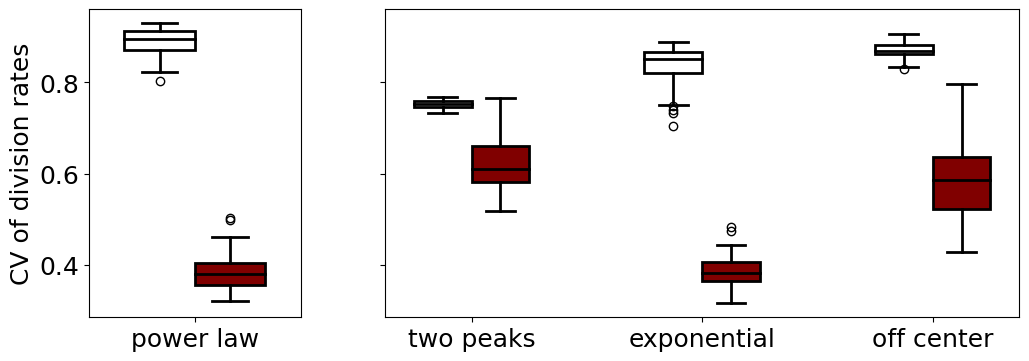

In [43]:
# Make one boxplot of CV of division rates for each field type, unoptimized and optimized
fig, ax = plt.subplots(1, 2, figsize=(12, 4), sharey=True, width_ratios=[1, 3])
boxplots = ax[1].boxplot([np.std(twopeaks.divrate, axis=1)/np.mean(twopeaks.divrate, axis=1), 
                np.std(twopeaks_opt.divrate, axis=1)/np.mean(twopeaks_opt.divrate, axis=1),
                np.std(exponential.divrate, axis=1)/np.mean(exponential.divrate, axis=1), 
                np.std(exponential_opt.divrate, axis=1)/np.mean(exponential_opt.divrate, axis=1),
                np.std(offcenter.divrate, axis=1)/np.mean(offcenter.divrate, axis=1), 
                np.std(offcenter_opt.divrate, axis=1)/np.mean(offcenter_opt.divrate, axis=1)],
            positions=[1, 1.5, 3, 3.5, 5, 5.5],
            widths=0.5,
            patch_artist=True);
boxplot_pl = ax[0].boxplot([np.std(powerlaw.divrate, axis=1)/np.mean(powerlaw.divrate, axis=1),
            np.std(powerlaw_opt.divrate, axis=1)/np.mean(powerlaw_opt.divrate, axis=1)],
            positions=[1, 1.5],
            widths=0.5,
            patch_artist=True);
labels=["two peaks", 
        "exponential",
        "off center"]
ax[0].set_xticks(ticks=[1.25,], labels=["power law"])
ax[1].set_xticks(ticks=[1.25, 3.25, 5.25], labels=labels)

box_colors=["white", "maroon"]
line_colors = ["black", "black"]
for i, box in enumerate(boxplot_pl['boxes']):
    box.set_facecolor(box_colors[i])
    box.set_edgecolor(line_colors[i])
    box.set_linewidth(2)
    boxplot_pl['medians'][i].set(color=line_colors[i], linewidth=2)
    boxplot_pl['whiskers'][i * 2].set(color=line_colors[i], linewidth=2)
    boxplot_pl['whiskers'][i * 2 + 1].set(color=line_colors[i], linewidth=2)
    boxplot_pl['caps'][i * 2].set(color=line_colors[i], linewidth=2)
    boxplot_pl['caps'][i * 2 + 1].set(color=line_colors[i], linewidth=2)

box_colors=["white", "maroon", "white", "maroon", "white", "maroon"]
line_colors = ["black", "black", "black", "black", "black", "black"]
for i, box in enumerate(boxplots['boxes']):
    box.set_facecolor(box_colors[i])
    box.set_edgecolor(line_colors[i])
    box.set_linewidth(2)
    boxplots['medians'][i].set(color=line_colors[i], linewidth=2)
    boxplots['whiskers'][i * 2].set(color=line_colors[i], linewidth=2)
    boxplots['whiskers'][i * 2 + 1].set(color=line_colors[i], linewidth=2)
    boxplots['caps'][i * 2].set(color=line_colors[i], linewidth=2)
    boxplots['caps'][i * 2 + 1].set(color=line_colors[i], linewidth=2)
    
ax[0].set_ylabel("CV of division rates")
plt.savefig('../data/paper/figures/field_boxplot.svg')

# Ablation Experiments

In [73]:
import copy

In [74]:
# Set chemical input weights to zero in the hidden state network and run forward simulation
# Order: chemical, chemgrads, stress
chem_inds = [0, 1, 2, 3, 4, 5]
stress_inds = [6]

ablate_chem_p = copy.deepcopy(params_all[0])
ablate_chem_p["hidden_fn"]['mlp/~/linear_0']['w'] = ablate_chem_p["hidden_fn"]['mlp/~/linear_0']['w'].at[chem_inds, :].set(np.zeros((len(chem_inds), 8)))

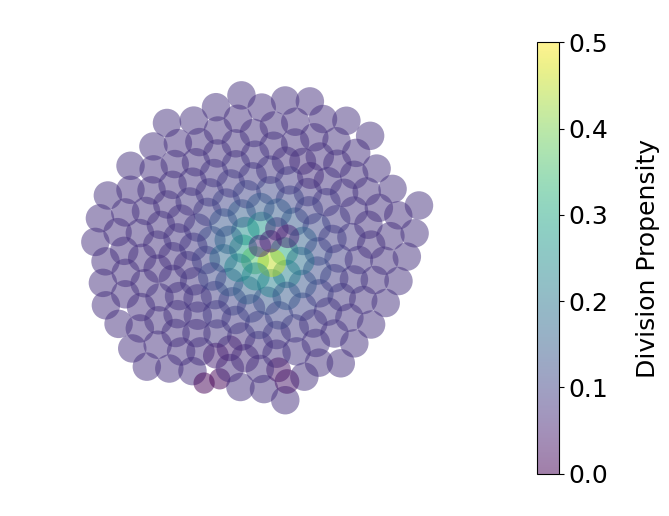

In [48]:
sim_init, sim_step = simulation(fstep, eqx.combine(ablate_chem_p, params), fspace)
fstate_opt, _ = sim_trajectory(istate, sim_init, sim_step, 100, key, history=False)
draw_circles(fstate_opt, fstate_opt.divrate, cm=plt.cm.viridis, min_val=0.0, max_val=0.5, cbar_title="Division Propensity");

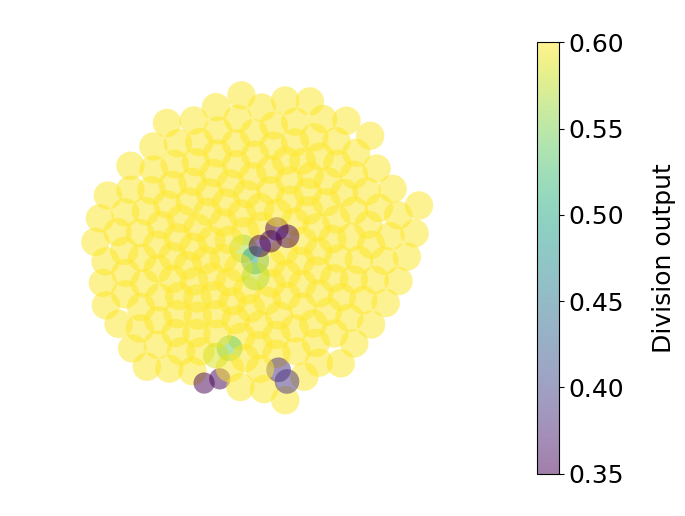

In [49]:
div_outputs = transform_fwd_inv(fstate_opt, fstate_opt.divrate)
draw_circles(fstate_opt, div_outputs, cm=plt.cm.viridis, cbar_title="Division output", min_val=0.35, max_val=0.6);

In [76]:
ablate_stress_p = copy.deepcopy(params_all[0])
ablate_stress_p["hidden_fn"]['mlp/~/linear_0']['w'] = ablate_stress_p["hidden_fn"]['mlp/~/linear_0']['w'].at[stress_inds, :].set(np.zeros((len(stress_inds), 8)))

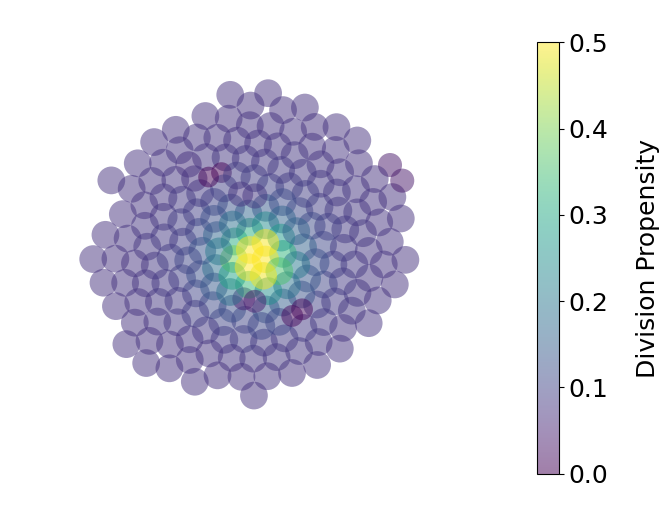

In [55]:
sim_init, sim_step = simulation(fstep, eqx.combine(ablate_stress_p, params), fspace)
fstate_opt, _ = sim_trajectory(istate, sim_init, sim_step, 100, key, history=False)
draw_circles(fstate_opt, fstate_opt.divrate, cm=plt.cm.viridis, min_val=0.0, max_val=0.5, cbar_title="Division Propensity");

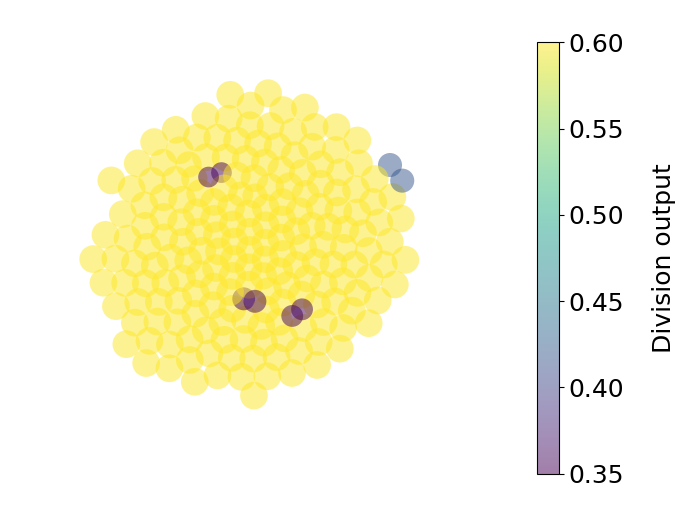

In [56]:
div_outputs = transform_fwd_inv(fstate_opt, fstate_opt.divrate)
draw_circles(fstate_opt, div_outputs, cm=plt.cm.viridis, cbar_title="Division output", min_val=0.35, max_val=0.6);

In [77]:
keys = random.split(key, 400)
unopt_fstates = run_sim_vmap(keys[:100], sim_init, sim_step, params, istate, 100)
opt_fstates = run_sim_vmap(keys[100:200], sim_init, sim_step, params_all[0], istate, 100)
opt_chem_ab_fstates = run_sim_vmap(keys[200:300], sim_init, sim_step, ablate_chem_p, istate, 100)
opt_stress_ab_fstates = run_sim_vmap(keys[300:], sim_init, sim_step, ablate_stress_p, istate, 100)

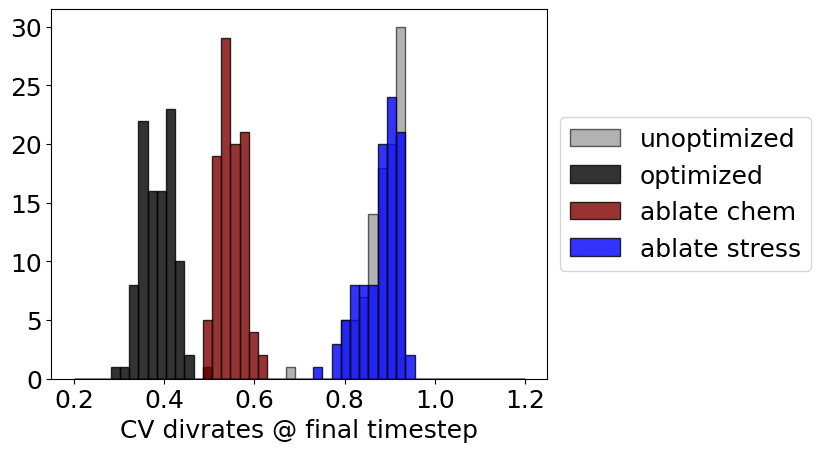

In [82]:
plt.hist(np.std(unopt_fstates.divrate, axis=1)/np.mean(unopt_fstates.divrate, axis=1), bins=np.linspace(0.2, 1.2, 50), edgecolor='black', label="unoptimized", color="gray", alpha=0.6);
plt.hist(np.std(opt_fstates.divrate, axis=1)/np.mean(opt_fstates.divrate, axis=1), bins=np.linspace(0.2, 1.2, 50), edgecolor='black', label="optimized", color="black", alpha=0.8);
plt.hist(np.std(opt_chem_ab_fstates.divrate, axis=1)/np.mean(opt_chem_ab_fstates.divrate, axis=1), bins=np.linspace(0.2, 1.2, 50), edgecolor='black', label="ablate chem", color="maroon", alpha=0.8);
plt.hist(np.std(opt_stress_ab_fstates.divrate, axis=1)/np.mean(opt_stress_ab_fstates.divrate, axis=1), bins=np.linspace(0.2, 1.2, 50), edgecolor='black', label="ablate stress", color="blue", alpha=0.8);
plt.xlabel("CV divrates @ final timestep");
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5));
plt.savefig('../data/paper/figures/ablations_plot.svg')

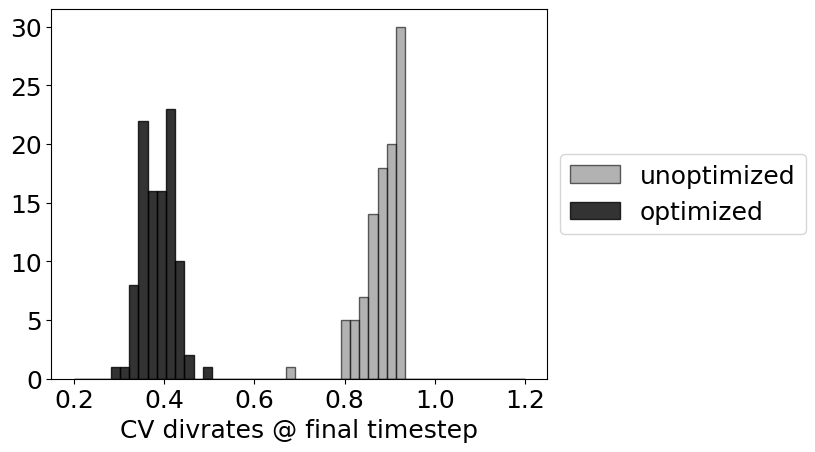

In [83]:
plt.hist(np.std(unopt_fstates.divrate, axis=1)/np.mean(unopt_fstates.divrate, axis=1), bins=np.linspace(0.2, 1.2, 50), edgecolor='black', label="unoptimized", color="gray", alpha=0.6);
plt.hist(np.std(opt_fstates.divrate, axis=1)/np.mean(opt_fstates.divrate, axis=1), bins=np.linspace(0.2, 1.2, 50), edgecolor='black', label="optimized", color="black", alpha=0.8);
plt.xlabel("CV divrates @ final timestep");
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5));
plt.savefig('../data/paper/figures/histograms_plot.svg')

# Optimization with new diffusion and independent cell divisions

In [20]:
from jax_morph.division_and_growth.cell_division import S_cell_div_indep
fstep = [
    # ENV CHANGES
    #S_cell_division,
    S_cell_div_indep,
    S_grow_cells,
    partial(S_mech_morse_relax, dt=.0001),
    partial(S_ss_chemfield, sec_fn=sec_nn_apply, n_iter=3),

    # SENSING
    #chemicals sensed directly
    S_chemical_gradients,
    S_fixed_chemfield,
    S_set_stress,
    # INTERNAL (HIDDEN) STATE
    partial(S_hidden_state, dhidden_fn=eqx.filter_jit(hid_nn_apply), state_decay=.0),
    # POLICIES
    partial(S_set_divrate, divrate_fn=eqx.filter_jit(div_nn_apply))
]

In [21]:
from jax import lax
@eqx.filter_jit
@eqx.filter_vmap(default=None, kwargs=dict(sim_key=0))
def loss(params, 
         hyper_params,
         fstep,
         fspace,
         istate,
         sim_key=None,
         metric_fn=None,
         metric_type='reward',
         REINFORCE=True,
         GAMMA=.99,
         ncells_add=None,
         init_multiplier=1,
         ):
    '''
    Reinforce loss on trajectory (with discounting). Rewards are differences in successive state metrics.

    If REINFORCE=False, then the loss is just the state measure on the final state.

    GAMMA is the discount factor for the calculation of the returns.

    If metric_type='reward', it is maximized, if metric_type='cost', it is minimized.

    '''

    #simulation length
    ncells_add = hyper_params['ncells_add'] if ncells_add is None else ncells_add
    
    def _sim_trajectory(istate, sim_init, sim_step, ncells_add, init_multiplier, key=None):

        state = sim_init(istate, ncells_add*init_multiplier, key)

        def scan_fn(state, i):
            state, logp = sim_step(state)
            measure = metric_fn(state)
            return state, (logp, measure)


        iterations = np.arange(ncells_add)
        fstate, aux = lax.scan(scan_fn, state, iterations)

        return fstate, aux

    # merge params dicts
    all_params = eqx.combine(params, hyper_params)

    #forward pass - simulation
    sim_init, sim_step = simulation(fstep, all_params, fspace)
    _, (logp, measures) = _sim_trajectory(istate, sim_init, sim_step, ncells_add, init_multiplier, sim_key)

    
    if REINFORCE:
        
        def _returns_rec(rewards):
            Gs=[]
            G=0
            for r in rewards[::-1]:
                G = r+G*GAMMA
                Gs.append(G)

            return np.array(Gs)[::-1]
        
        
        measures = np.append(np.array([metric_fn(istate)]),measures)
        
        if metric_type=='reward':
            rewards = np.diff(measures)
        elif metric_type=='cost':
            rewards = -np.diff(measures)


        returns = _returns_rec(rewards)

        # standardizing returns helps with convergence
        returns = (returns-returns.mean())/(returns.std()+1e-8)

        loss = -np.sum(logp*lax.stop_gradient(returns))

        return loss

    else:
        return measures[-1]
    
def avg_loss(params, hyper_params, vloss_fn, sim_keys, **kwargs):
    
    lss = vloss_fn(params, hyper_params, sim_key=sim_keys, **kwargs)
    
    return np.mean(lss)

In [22]:
from jax import value_and_grad
import optax

def cv_divrates(state):
    ''' 
    Coefficient of variation of division rates loss.
    '''
    return np.power(np.std(state.divrate)/np.mean(state.divrate), 2)


def train(key,
          params, train_params, 
          EPOCHS, 
          EPISODES_PER_UPDATE, 
          EPISODES_PER_EVAL, 
          LEARNING_RATE, 
          rloss, 
          sloss, 
          fstep, 
          fspace, 
          istate,
          normalize_grads=True,
          ):

    p, hp = eqx.partition(params, train_params)

    # init optimizer
    optimizer = optax.adam(LEARNING_RATE)
    opt_state = optimizer.init(p)


    #--------------------------------------------
    #store loss at initial params and calc grad 

    key, *batch_subkeys = random.split(key, EPISODES_PER_UPDATE+1)
    batch_subkeys = np.array(batch_subkeys)

    ll, grads = value_and_grad(avg_loss)(p, hp, rloss, batch_subkeys, fspace=fspace, fstep=fstep, istate=istate)


    key, *eval_subkeys = random.split(key, EPISODES_PER_EVAL+1)
    eval_subkeys = np.array(eval_subkeys)

    l = avg_loss(p, hp, sloss, eval_subkeys, fstep=fstep, fspace=fspace, istate=istate)
    print(float(l))
    #store initial params and loss
    loss_t = [float(l)]
    params_t = [p]
    grads_t = [grads]

    #--------------------------------------------


    for t in range(EPOCHS):
        #generate batch of random keys
        key, *batch_subkeys = random.split(key, EPISODES_PER_UPDATE+1)
        batch_subkeys = np.array(batch_subkeys)
        #normalize grads
        if normalize_grads:
            grads = tree_map(lambda x: x/(np.linalg.norm(x)+1e-10), grads)
        # sgd step
        updates, opt_state = optimizer.update(grads, opt_state, p)

        p = eqx.apply_updates(p, updates)
    
        #clip diffCoeff if trained
        if None != p['diffCoeff']:
            p['diffCoeff'] = np.clip(p['diffCoeff'],.2)
    
        #estimate actual avg loss
        key, *eval_subkeys = random.split(key, EPISODES_PER_EVAL+1)
        eval_subkeys = np.array(eval_subkeys)

        l = avg_loss(p, hp, sloss, eval_subkeys, fstep=fstep, fspace=fspace, istate=istate)
    
        # surrogate loss and grads
        ll, grads = value_and_grad(avg_loss)(p, hp, rloss, batch_subkeys, fstep=fstep, fspace=fspace, istate=istate)


        #store
        loss_t += [float(l)]
        params_t += [p]
        grads_t += [grads]   
        print(float(l))
    return loss_t, params_t, grads_t



# First learn homogeneous growth parameters.
def optimize(key, params, train_params, istate, EPOCHS, EPISODES_PER_UPDATE, EPISODES_PER_EVAL, LEARNING_RATE):
    rloss = eqx.filter_jit(partial(loss, metric_fn=cv_divrates, REINFORCE=True, metric_type='cost', GAMMA=0.95, init_multiplier=10))
    sloss = eqx.filter_jit(partial(loss, metric_fn=cv_divrates, metric_type='cost', REINFORCE=False, init_multiplier=10))    
    loss_t, params_t, grads_t = train(key, params, train_params, EPOCHS, EPISODES_PER_UPDATE, EPISODES_PER_EVAL, LEARNING_RATE, rloss, sloss, fstep, fspace, istate)
    return loss_t, params_t, grads_t

In [52]:
params["ncells_add"] = 10

In [62]:
loss, opt_params, grads = optimize(key, params, train_params, istate, 100, EPISODES_PER_UPDATE, EPISODES_PER_EVAL, LEARNING_RATE)

1.2208831310272217
1.18802809715271
1.145703911781311
1.2759422063827515
1.2808924913406372
1.285277247428894
1.381143569946289
1.329075813293457
1.3297467231750488
1.3339473009109497
1.2649554014205933
1.2644312381744385
1.238197922706604
1.2464301586151123
1.271304965019226
1.225795865058899
1.2029350996017456
1.238869547843933
1.2638602256774902
1.2362759113311768
1.23233962059021
1.085471749305725
1.0939546823501587
1.0285283327102661
1.0480453968048096
1.0011980533599854
1.0071687698364258
0.9352996945381165
0.9588868021965027
0.9820649027824402
0.8478773236274719
0.7702405452728271
0.7868916392326355
0.7812009453773499
0.7730976939201355
0.7605523467063904
0.7724930644035339
0.8062928318977356
0.7395615577697754
0.7226306200027466
0.6740216612815857
0.6745652556419373
0.6236467957496643
0.6174675822257996
0.5771428942680359
0.6584237217903137
0.6210341453552246
0.586322009563446
0.610802948474884
0.598949670791626
0.640847384929657
0.5895004272460938
0.5211979746818542
0.53027856

In [24]:
EPOCHS = 100
EPISODES_PER_UPDATE = 20
EPISODES_PER_EVAL = 20
LEARNING_RATE = 0.01
key = random.PRNGKey(0)

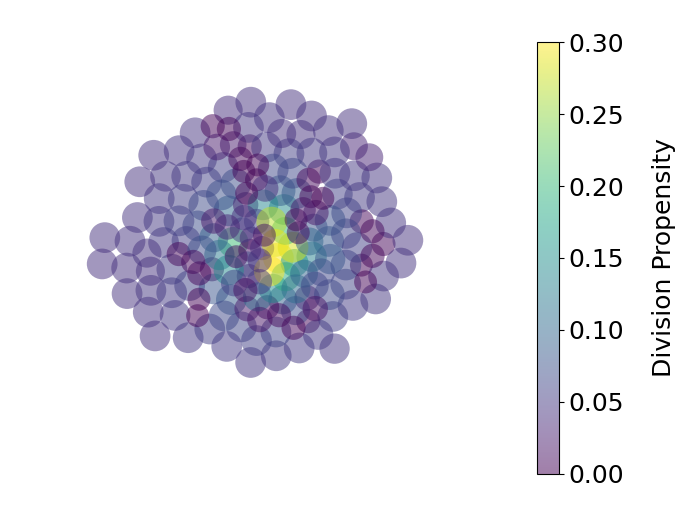

In [63]:
sim_init, sim_step = simulation(fstep, params, fspace)
fstate, _ = sim_trajectory(istate, sim_init, sim_step, init_multiplier=10, n_steps=10, key=key, history=False)
draw_circles(fstate, fstate.divrate, cm=plt.cm.viridis, min_val=0.0, max_val=0.3, cbar_title="Division Propensity");
#plt.savefig('../data/paper/figures/divrates_opt.svg')

/n/home10/rdeshpande/morphogenesis/jax-morph/jax_morph/cell_internals/secretion.py:79: FutureWarning: jax.tree_leaves is deprecated, and will be removed in a future release. Use jax.tree_util.tree_leaves instead.
  in_fields = np.hstack([f if len(f.shape)>1 else f[:,np.newaxis] for f in jax.tree_leaves(eqx.filter(state, use_state_fields))])


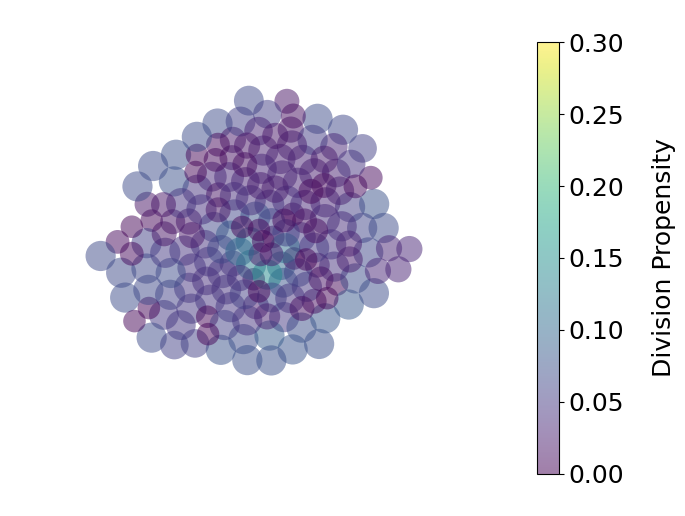

In [65]:
sim_init, sim_step = simulation(fstep, eqx.combine(opt_params[-1], params), fspace)
fstate_opt, _ = sim_trajectory(istate, sim_init, sim_step, init_multiplier=10, n_steps=10, key=key, history=False)
draw_circles(fstate_opt, fstate_opt.divrate, cm=plt.cm.viridis, min_val=0.0, max_val=0.3, cbar_title="Division Propensity");
#plt.savefig('../data/paper/figures/divrates_opt.svg')

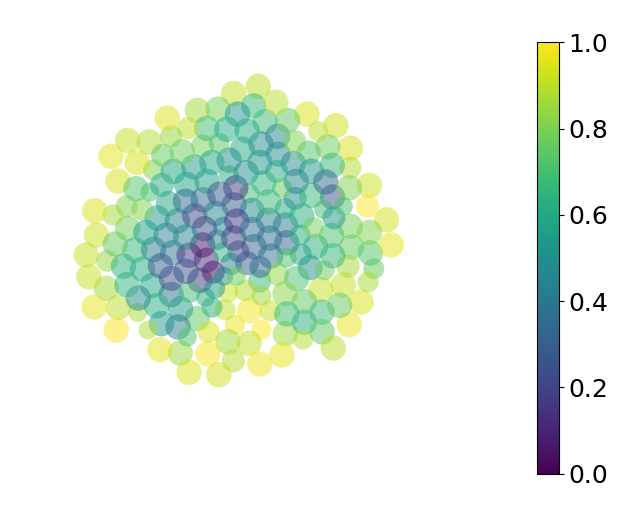

In [73]:
#sim_init, sim_step = simulation(fstep, eqx.combine(opt_params[-1], params), fspace)
#fstate_opt, _ = sim_trajectory(istate, sim_init, sim_step, 100, key, history=False)
draw_circles(fstate_opt, fstate_opt.stress, cm=plt.cm.viridis);
#plt.savefig('../data/paper/figures/divrates_opt.svg')

In [44]:
train_params

{'n_chem': False,
 'n_dim': False,
 'sec_max': True,
 'ctype_sec_chem': False,
 'cellRad': False,
 'cellRadBirth': False,
 'diffCoeff': True,
 'degRate': False,
 'r_onsetDiff': False,
 'r_cutoffDiff': False,
 'alpha': False,
 'eps_OneOne': False,
 'r_onset': False,
 'r_cutoff': False,
 'mech_relaxation_steps': False,
 'ncells_init': False,
 'ncells_add': False,
 'chem_max': False,
 'hidden_state_size': False,
 'hidden_fn': {'mlp/~/linear_0': {'b': True, 'w': True},
  'mlp/~/linear_1': {'b': True, 'w': True}},
 'div_fn': {'mlp/~/linear_0': {'b': True, 'w': True}},
 'sec_fn': {'mlp/~/linear_0': {'b': True, 'w': True}}}